In [1]:
%matplotlib inline

import os
import pandas
import numpy
import sklearn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
polls_file_name = 'full_bracket.poll_of_polls.csv'
streak_file_name = 'composite_streak_data.csv'
#points_file_name =  'team_points.csv'


polls = pandas.read_csv(polls_file_name, sep='|')
streak = pandas.read_csv(streak_file_name, sep='|').drop('Unnamed: 0', axis=1)
#points = pandas.read_csv(points_file_name, sep='|').drop('Unnamed: 0', axis=1)

polls[:5]

,Team,rank,TeamID,norm_rank,Season,noise
0,Kansas,11.000000,1242,0.000000,2010,-0.388046
1,Kentucky,11.000000,1246,0.000000,2010,0.356803
2,Duke,11.000000,1181,0.000000,2010,0.019042
3,Syracuse,11.000000,1393,0.000000,2010,0.405093
4,West Virginia,11.555556,1452,0.010678,2010,-0.060610


In [3]:
# Brooklyn is missing from the data somehow - so add them in by hand

polls = polls.append(pandas.DataFrame({'Season': [2018], 
                                       'TeamID': [1134], 
                                       'Team': ['Brooklyn'], 
                                       'rank': [267],
                                       'norm_rank': [5.0],
                                       'noise': [0.0]}))
for streak_len in [2, 3, 4, 6, 8, 10]:
    streak = streak.append(pandas.DataFrame({'Season': [2018], 
                                             'TeamID': [1134], 
                                             'TeamName': ['Brooklyn'], 
                                             'streak': [0.5],
                                             'StreakLen': [streak_len]}))


In [4]:
alpha = -0.1
beta = 0.05
streak_len = 10

a = polls[polls['Season'] == 2018][['TeamID', 'Team', 'norm_rank']]
b = streak[(streak['Season'] == 2018) & (streak['StreakLen'] == streak_len)][['TeamID', 'streak']]

w = a.merge(b, on='TeamID', how='left')

w['Rank'] = w['norm_rank'] - alpha*w['streak'] + beta*(numpy.random.random(w.shape[0]) - 0.5)

# Injury penalty applied to Virginia
#w.loc[w['TeamID'] == 1438, 'streak'] = 0.9
w.loc[w['TeamID'] == 1438, 'streak'] = 0.0

In [5]:
teams = pandas.read_csv('data/kaggle_2018_final/DataFiles/Teams.csv')
slots = pandas.read_csv('slots_2018.csv')
seeds = pandas.read_csv('seeds_2018.csv')


In [65]:
def round_results(r):
    season = 2018
    daynum = -1
    wloc = 'X'
    numot = -1

    results = {
        'Season': list(),
        'DayNum': list(),
        'WTeamID': list(),
        'WScore': list(),
        'LTeamID': list(),
        'LScore': list(),
        'WLoc': list(),
        'NumOT': list(),
        'minID': list(),
        'maxID': list()
    }
    
    for idx, row in r.iterrows():
        sid = row['StrongTeamID']
        wid = row['WeakTeamID']

        #print sid, wid, all([~numpy.isnan(sid), ~numpy.isnan(wid)]), row['StrongTeamRank'] > row['WeakTeamRank']

        if all([~numpy.isnan(sid), ~numpy.isnan(wid)]):    
            minid = min(sid, wid)
            maxid = max(sid, wid)
            
            # Play-in results:
            if (minid, maxid) == (1382, 1417):
                # UCLA: 1417 (58), St Bonaventure: 1382 (65)
                win_id  = 1382
                loss_id = 1417
                win_sc  = 65
                loss_sc = 58
            elif (minid, maxid) == (1134, 1347):
                # Radford: 1347 (71), Brooklyn: 1134 (61)
                win_id  = 1347
                loss_id = 1134
                win_sc  = 71
                loss_sc = 61
            elif (minid, maxid) == (1300, 1411):
                # TX Southern: 1411 (64), NC Central: 1300 (46)
                win_id  = 1411
                loss_id = 1300
                win_sc  = 64
                loss_sc = 46
            elif (minid, maxid) == (1113, 1393):
                # Arizona St: 1113 (56), Syracuse: 1393 (60) 
                win_id  = 1393
                loss_id = 1113
                win_sc  = 60
                loss_sc = 56
            elif row['StrongTeamRank'] <= row['WeakTeamRank']:
                # Strong seed is higher ranked and wins
                win_id = sid
                loss_id = wid
                win_sc = 1
                loss_sc = 0
            else:
                # Week seed is higher ranked and wins
                win_id = wid
                loss_id = sid
                win_sc = 1
                loss_sc = 0

            results['Season'].append(season)
            results['DayNum'].append(daynum)
            results['WTeamID'].append(win_id)
            results['WScore'].append(win_sc)
            results['LTeamID'].append(loss_id)
            results['LScore'].append(loss_sc)
            results['WLoc'].append(wloc)
            results['NumOT'].append(numot)
            results['minID'].append(minid)
            results['maxID'].append(maxid)

    results = pandas.DataFrame(results)
    
    return results

In [7]:
scenarios = [
    {'alpha':  0.0, 'beta': 0.00, 'streak': None, 'model': 'p',  'output': 'data/brackets/bracket_pp'},
    {'alpha':  0.0, 'beta': 0.01, 'streak': None, 'model': 'b',  'output': 'data/brackets/bracket_a00_b001_sNA'},
    {'alpha':  0.0, 'beta': 0.05, 'streak': None, 'model': 'b',  'output': 'data/brackets/bracket_a00_b005_sNA'},
    {'alpha': -0.1, 'beta': 0.00, 'streak': 6,    'model': 'a',  'output': 'data/brackets/bracket_a01_b000_s06'},
    {'alpha': -0.1, 'beta': 0.01, 'streak': 6,    'model': 'ab', 'output': 'data/brackets/bracket_a01_b001_s06'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 6,    'model': 'ab', 'output': 'data/brackets/bracket_a01_b005_s06'},
    {'alpha': -0.1, 'beta': 0.00, 'streak': 10,   'model': 'a',  'output': 'data/brackets/bracket_a01_b000_s10'},
    {'alpha': -0.1, 'beta': 0.01, 'streak': 10,   'model': 'ab', 'output': 'data/brackets/bracket_a01_b001_s10'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 10,   'model': 'ab', 'output': 'data/brackets/bracket_a01_b005_s10'},
    {'alpha': -0.2, 'beta': 0.00, 'streak': 6,    'model': 'a',  'output': 'data/brackets/bracket_a02_b000_s06'},
    {'alpha': -0.2, 'beta': 0.01, 'streak': 6,    'model': 'ab', 'output': 'data/brackets/bracket_a02_b001_s06'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 6,    'model': 'ab', 'output': 'data/brackets/bracket_a02_b005_s06'},
    {'alpha': -0.2, 'beta': 0.00, 'streak': 10,   'model': 'a',  'output': 'data/brackets/bracket_a02_b000_s10'},
    {'alpha': -0.2, 'beta': 0.01, 'streak': 10,   'model': 'ab', 'output': 'data/brackets/bracket_a02_b001_s10'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 10,   'model': 'ab', 'output': 'data/brackets/bracket_a02_b005_s10'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 6,  'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s06_pen'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 10, 'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s10_pen'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 6,  'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a02_b005_s06_pen'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 10, 'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a02_b005_s10_pen'}
    {'alpha': -0.1, 'beta': 0.05, 'streak': 6,  'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s06_pen'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 10, 'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s10_pen'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 6,  'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a02_b005_s06_pen'},
    {'alpha': -0.2, 'beta': 0.05, 'streak': 10, 'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a02_b005_s10_pen'}
]

SyntaxError: invalid syntax (<ipython-input-7-6c8b6b9e91d8>, line 21)

In [ ]:
scenarios_select = [
    {'alpha':  0.0, 'beta': 0.01, 'streak': None, 'model': 'b',                   'output': 'data/brackets/bracket_a00_b001_sNA'},
    {'alpha': -0.1, 'beta': 0.01, 'streak': 6,    'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b001_s06_pen'},
    {'alpha': -0.1, 'beta': 0.01, 'streak': 10,   'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b001_s10_pen'},
    {'alpha':  0.0, 'beta': 0.05, 'streak': None, 'model': 'b',                   'output': 'data/brackets/bracket_a00_b005_sNA'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 6,    'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s06_pen'},
    {'alpha': -0.1, 'beta': 0.00, 'streak': 10,   'model': 'a', 'penalty': True, 'output': 'data/brackets/bracket_a01_b005_s10_pen'},
]

In [66]:
scenarios_select = [
    # Deterministic scenarios
    {'alpha':  0.0, 'beta': 0.00, 'streak': None, 'model': 'p',                   'output': 'data/brackets/bracket_pp'},
    {'alpha': -0.1, 'beta': 0.00, 'streak':  6,   'model': 'a',                   'output': 'data/brackets/bracket_a01_b00_s06'},
    {'alpha': -0.1, 'beta': 0.00, 'streak': 10,   'model': 'a', 'penalty': True,  'output': 'data/brackets/bracket_a01_b00_s10_pen'},
    {'alpha': -0.2, 'beta': 0.00, 'streak':  6,   'model': 'a',                   'output': 'data/brackets/bracket_a02_b00_s06'},
    {'alpha': -0.2, 'beta': 0.00, 'streak': 10,   'model': 'a', 'penalty': True,  'output': 'data/brackets/bracket_a02_b00_s10_pen'},

    # Random scenarios
    {'alpha':  0.0, 'beta': 0.05, 'streak': None, 'model': 'b',                   'output': 'data/brackets/bracket_a00_b05_sNA'},    
    {'alpha':  0.0, 'beta': 0.15, 'streak': None, 'model': 'b',                   'output': 'data/brackets/bracket_a00_b15_sNA'},    
    {'alpha': -0.1, 'beta': 0.05, 'streak': 6,    'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b05_s06_pen'},
    {'alpha': -0.1, 'beta': 0.05, 'streak': 10,   'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b05_s10_pen'},
    {'alpha': -0.1, 'beta': 0.15, 'streak': 6,    'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b15_s06_pen'},
    {'alpha': -0.1, 'beta': 0.15, 'streak': 10,   'model': 'ab', 'penalty': True, 'output': 'data/brackets/bracket_a01_b15_s10_pen'},
]

In [67]:
season = 2018
trials = 200

stats = dict()

all_winners = dict()

for scn in scenarios_select:

    alpha       = scn['alpha']
    beta        = scn['beta']
    streak_len  = scn['streak']
    penalty     = scn.get('penalty', False)
    model       = scn['model']
    output_path = scn['output']

    print 'Scenario: {} Penalty: {}'.format(output_path, penalty)
    
    final_teams = list()

    # Only do one trial if the model does not contain noise
    if model in ['p', 'a']:
        n_trials = 1
    else:
        n_trials = trials
          
    winners = dict([rnd, list()] for rnd in [1, 2, 3, 4, 5, 6])
            
    for tr in range(n_trials):
        # print '    {}'.format(tr)
        
        a = polls[polls['Season'] == 2018][['TeamID', 'Team', 'norm_rank']]
        b = streak[(streak['Season'] == 2018) & (streak['StreakLen'] == streak_len)][['TeamID', 'streak']]
        w = a.merge(b, on='TeamID', how='left')
        
        if model == 'p':
            w['Rank'] = w['norm_rank']
        elif model == 'a':
            w['Rank'] = w['norm_rank'] - alpha*w['streak']
        elif model == 'b':
            # noise is added round-by-round
            w['Rank'] = w['norm_rank'] # + beta*(numpy.random.random(w.shape[0]) - 0.5)
        elif model == 'ab':
            # noise is added round-by-round
            w['Rank'] = w['norm_rank'] - alpha*w['streak'] # + beta*(numpy.random.random(w.shape[0]) - 0.5)
        else:
            raise ValueError('Incorrect model: {}'.format(model))
            
        # Injury penalty applied to Virginia
        if penalty:
            w.loc[w['TeamID'] == 1438, 'streak'] = 0.0

        bracket = w[['TeamID', 'Rank']]
            
        # initialize
        df = slots.merge(seeds, left_on=['Season', 'StrongSeed'], right_on=['Season', 'Seed'], how='left')
        df = df.rename(index=str, columns={"TeamID": "StrongTeamID"}).drop('Seed', axis=1)
        df = df.merge(seeds, left_on=['Season', 'WeakSeed'], right_on=['Season', 'Seed'], how='left')
        df = df.rename(index=str, columns={"TeamID": "WeakTeamID"}).drop('Seed', axis=1)

        # reduce to the 68 teams in the tourney
        # teams_68 = map(int, list(df['StrongTeamID']) + list(df['WeakTeamID']))
        teams_68 = map(int, set([id for id in list(df['StrongTeamID']) + list(df['WeakTeamID']) if not numpy.isnan(id)]))
        bracket_68 = bracket[bracket['TeamID'].isin(teams_68)].copy()
        initial_rank_68 = bracket_68['Rank'].copy()
        full_bracket_68 = bracket_68.copy()
                
        # Add noise
        if beta > 0.0:
            bracket_68['Rank'] = initial_rank_68 + numpy.random.normal(scale=beta, size=bracket_68.shape[0]) 
        else:
            bracket_68['Rank'] = initial_rank_68 
        full_bracket_68['Rank_0'] = bracket_68['Rank'].copy()
        
        df = df.merge(bracket_68, left_on='StrongTeamID', right_on='TeamID', how='left')
        df = df.rename(index=str, columns={"Rank": "StrongTeamRank"}).drop('TeamID', axis=1)
        df = df.merge(bracket_68, left_on='WeakTeamID', right_on='TeamID', how='left')
        df = df.rename(index=str, columns={"Rank": "WeakTeamRank"}).drop('TeamID', axis=1)

        # play-in games
        pi_games = ~(df['Slot'].str.contains('R')) & (df['Season'] == season)
        pi = df[pi_games]

        pi.loc[pi_games, 'minID'] = pi[['StrongTeamID', 'WeakTeamID']].min(axis=1)
        pi.loc[pi_games, 'maxID'] = pi[['StrongTeamID', 'WeakTeamID']].max(axis=1)

        results = round_results(pi)

        pi = pi.merge(results, on=['Season', 'minID', 'maxID'], how='left')

        pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
        pi = pi.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
        pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
        pi = pi.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
        pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
        pi = pi.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
        pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
        pi = pi.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

        # regular rounds
        rounds = [pi]

        for rnd in range(1, 6 + 1):
            last_rnd = rounds[-1]

            r_games = (df['Slot'].str.contains('R{}..'.format(rnd))) & (df['Season'] == season)
            r = df[r_games]

            r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='StrongSeed', right_on='Slot', how='left', suffixes=['', '__'])
            r.loc[r['StrongTeamID'].isnull(), 'StrongTeamID'] = r['WTeamID']
            r = r.drop(['Slot__', 'WTeamID'], axis=1)

            r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='WeakSeed', right_on='Slot', how='left', suffixes=['', '__'])
            r.loc[r['WeakTeamID'].isnull(), 'WeakTeamID'] = r['WTeamID']
            r = r.drop(['Slot__', 'WTeamID'], axis=1)

            r['minID'] = r[['StrongTeamID', 'WeakTeamID']].min(axis=1)
            r['maxID'] = r[['StrongTeamID', 'WeakTeamID']].max(axis=1)


            # Add noise and update ranks
            if beta > 0.0:
                bracket_68['Rank'] = initial_rank_68 + numpy.random.normal(scale=beta/float(rnd), size=bracket_68.shape[0])
            else:
                bracket_68['Rank'] = initial_rank_68 

            full_bracket_68['Rank_{}'.format(rnd)] = bracket_68['Rank'].copy()
    
            r['StrongTeamRank'] = r.merge(bracket_68, left_on='StrongTeamID', right_on='TeamID', how='left')['Rank']
            r['WeakTeamRank'] = r.merge(bracket_68, left_on='WeakTeamID', right_on='TeamID', how='left')['Rank']

            results = round_results(r)
            
            r = r.merge(results, on=['Season', 'minID', 'maxID'], how='left')

            r = r.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
            r = r.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
            r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
            r = r.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
            r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
            r = r.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
            r = r.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
            r = r.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

            winners[rnd].append(list(r['WTeamName']))
            
            rounds.append(r.copy())

        bracket_file_name = '{}_{:04}.csv'.format(output_path, tr)
        full_bracket_68.to_csv(bracket_file_name, sep='|', header=True, index=False)
    
        final = list()
        for rnd in [5, 6]:
            for idx, row in rounds[rnd][['WTeamName', 'LTeamName']].iterrows():
                final.append((row['WTeamName'], row['LTeamName']))

        final_teams.append(tuple(final))
        
        # Collect some stats
        mc = Counter(final_teams).most_common()
        
        flat = list()
        for ctr, item in enumerate(mc):
            copies = [reduce(lambda x, y: x + y, item[0]) for i in range(item[1])]
            flat.extend(copies)
           
        slot_results = {'slot': list(), 'team': list(), 'pct': list()}
        for k, t in enumerate(zip(*flat)):
            z = len(t)
            for ctr, item in enumerate(Counter(t).most_common()):
                if k in [0, 2, 4]:
                    slot_results['slot'].append(k)
                    slot_results['team'].append(item[0])
                    slot_results['pct'].append(item[1]/float(z))
            
        stats[output_path] = {'most_common': mc,
                              'slot_results': slot_results}
        
        all_winners[output_path] = winners


Scenario: data/brackets/bracket_pp Penalty: False
Scenario: data/brackets/bracket_a01_b00_s06 Penalty: False
Scenario: data/brackets/bracket_a01_b00_s10_pen Penalty: True
Scenario: data/brackets/bracket_a02_b00_s06 Penalty: False
Scenario: data/brackets/bracket_a02_b00_s10_pen Penalty: True
Scenario: data/brackets/bracket_a00_b05_sNA Penalty: False
Scenario: data/brackets/bracket_a00_b15_sNA Penalty: False
Scenario: data/brackets/bracket_a01_b05_s06_pen Penalty: True
Scenario: data/brackets/bracket_a01_b05_s10_pen Penalty: True
Scenario: data/brackets/bracket_a01_b15_s06_pen Penalty: True
Scenario: data/brackets/bracket_a01_b15_s10_pen Penalty: True


In [69]:
rounds_output_file = 'rounds_win_pct.final.csv'
with open(rounds_output_file, 'w') as output_file:
    print '|'.join(['Scenario', 'Round', 'Team', 'Win_Pct'])
    for scn, winners in all_winners.iteritems():
        for rnd in [1, 2, 3, 4, 5, 6]:
            z = float(len(winners[rnd]))
            for team, ws in sorted(Counter(reduce(lambda x, y: x + y, winners[rnd])).iteritems()):
                print '|'.join(map(str, [scn, rnd, team, ws/z]))
                print >> output_file, '|'.join(map(str, [scn, rnd, team, ws/z]))

Scenario|Round|Team|Win_Pct
data/brackets/bracket_a02_b00_s10_pen|1|Arizona|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Arkansas|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Auburn|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Cincinnati|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Clemson|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Creighton|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Duke|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Florida|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Florida St|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Gonzaga|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Houston|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Kansas|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Kentucky|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Miami FL|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Michigan|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Michigan St|1.0
data/brackets/bracket_a02_b00_s10_pen|1|Nevada|1.0
data/brackets/bracket_a02_b00_s10_pen|1|North Carolina|1.0
data/brackets/brack

In [24]:
data/brackets/bracket_a00_b05_sNA|5|Cincinnati|0.33
data/brackets/bracket_a00_b05_sNA|5|Kansas|0.04
data/brackets/bracket_a00_b05_sNA|5|Michigan St|0.1
data/brackets/bracket_a00_b05_sNA|5|North Carolina|0.02
data/brackets/bracket_a00_b05_sNA|5|Villanova|0.86
data/brackets/bracket_a00_b05_sNA|5|Virginia|0.65

,DayNum,LScore,LTeamID,NumOT,Season,WLoc,WScore,WTeamID,maxID,minID
0,-1,0,1300.0,-1,2018,X,1,1411.0,1411.0,1300.0
1,-1,58,1417.0,-1,2018,X,65,1382.0,1417.0,1382.0
2,-1,61,1134.0,-1,2018,X,71,1347.0,1347.0,1134.0
3,-1,0,1393.0,-1,2018,X,1,1113.0,1393.0,1113.0


In [61]:
.33 + .04 + .1 + .02 + .86 + .65

2.0

In [62]:
.17 + .01 + .47 + .35

1.0

In [ ]:
data/brackets/bracket_a01_b05_s06_pen|4|Cincinnati|0.35
data/brackets/bracket_a01_b05_s06_pen|4|Duke|0.3
data/brackets/bracket_a01_b05_s06_pen|4|Kansas|0.38
data/brackets/bracket_a01_b05_s06_pen|4|Michigan St|0.32
data/brackets/bracket_a01_b05_s06_pen|4|North Carolina|0.99
data/brackets/bracket_a01_b05_s06_pen|4|Villanova|1.0
data/brackets/bracket_a01_b05_s06_pen|4|Virginia|0.65
data/brackets/bracket_a01_b05_s06_pen|4|Xavier|0.01

In [63]:
.35+.3+.38+.32+.99+1+.65+.01

3.9999999999999996

In [25]:
results_pi = results.copy()

# TX Southern: 1411, NC Central: 1300
# UCLA: 1417, St Bonaventure: 1382
# Radford: 1347, Brooklyn: 1134
# Arizona St: 1113, Syracuse: 1393


In [26]:
r2 = results_pi.merge(bracket_68, left_on='WTeamID', right_on='TeamID', how='left')
r2 = r2.merge(seeds[['TeamID', 'Seed']], on='TeamID', how='left')
r2 = r2.merge(teams[['TeamID', 'TeamName']], on='TeamID', how='left')
r2 = r2.rename(index=str, columns={"TeamName": "WTeamName", "Seed": "WSeed", "Rank": "WRank"}).drop('TeamID', axis=1)


r2 = r2.merge(bracket_68, left_on='LTeamID', right_on='TeamID', how='left')
r2 = r2.merge(seeds[['TeamID', 'Seed']], on='TeamID', how='left')
r2 = r2.merge(teams[['TeamID', 'TeamName']], on='TeamID', how='left')
r2 = r2.rename(index=str, columns={"TeamName": "LTeamName", "Seed": "LSeed", "Rank": "LRank"}).drop('TeamID', axis=1)

r2

,DayNum,LScore,LTeamID,NumOT,Season,WLoc,WScore,WTeamID,maxID,minID,WRank,WSeed,WTeamName,LRank,LSeed,LTeamName
0,-1,0,1300.0,-1,2018,X,1,1411.0,1411.0,1300.0,4.181614,W16b,TX Southern,5.147506,W16a,NC Central
1,-1,58,1417.0,-1,2018,X,65,1382.0,1417.0,1382.0,0.844215,Y11a,St Bonaventure,0.675576,Y11b,UCLA
2,-1,61,1134.0,-1,2018,X,71,1347.0,1347.0,1134.0,3.013266,Y16b,Radford,5.000000,Y16a,Brooklyn
3,-1,0,1393.0,-1,2018,X,1,1113.0,1393.0,1113.0,0.660884,Z11a,Arizona St,0.739393,Z11b,Syracuse


In [373]:
r2 = results.merge(bracket_68, left_on='WTeamID', right_on='TeamID', how='left')
r2 = r2.merge(seeds[['TeamID', 'Seed']], on='TeamID', how='left')
r2 = r2.merge(teams[['TeamID', 'TeamName']], on='TeamID', how='left')
r2 = r2.rename(index=str, columns={"TeamName": "WTeamName", "Seed": "WSeed", "Rank": "WRank"}).drop('TeamID', axis=1)

r2 = r2.merge(bracket_68, left_on='LTeamID', right_on='TeamID', how='left')
r2 = r2.merge(seeds[['TeamID', 'Seed']], on='TeamID', how='left')
r2 = r2.merge(teams[['TeamID', 'TeamName']], on='TeamID', how='left')
r2 = r2.rename(index=str, columns={"TeamName": "LTeamName", "Seed": "LSeed", "Rank": "LRank"}).drop('TeamID', axis=1)
r2['WRank_diff_LRank'] = r2['WRank'] - r2['LRank']

r2[r2['WSeed'].str.contains('06|07|08')] \
.sort_values('WRank_diff_LRank') \
[['WSeed', 'WTeamName', 'WRank', 'LSeed', 'LTeamName', 'LRank', 'WRank_diff_LRank']] \
.quantile(0.5)

WRank              NaN
LRank              NaN
WRank_diff_LRank   NaN
dtype: float64

In [374]:
r2[(r2['WSeed'].str.contains('06|07|08|09|10|11')) | (r2['LSeed'].str.contains('06|07|08|09|10|11')) ] \
.sort_values('WRank_diff_LRank') \
[['WSeed', 'WTeamName', 'WRank', 'LSeed', 'LTeamName', 'LRank', 'WRank_diff_LRank']]

,WSeed,WTeamName,WRank,LSeed,LTeamName,LRank,WRank_diff_LRank


In [360]:
r2[(r2['WSeed'].str.contains('06|07|08|09|10|11')) | (r2['LSeed'].str.contains('06|07|08|09|10|11')) ] \
.sort_values('WRank_diff_LRank') \
[['WSeed', 'WTeamName', 'WRank', 'LSeed', 'LTeamName', 'LRank', 'WRank_diff_LRank']]

,WSeed,WTeamName,WRank,LSeed,LTeamName,LRank,WRank_diff_LRank
5,W06,Houston,0.301785,W11,San Diego St,0.970115,-0.668329
6,W07,Texas A&M,0.416185,W10,Providence,0.823073,-0.406888
21,Y06,Florida,0.370646,Y11b,UCLA,0.735576,-0.364931
29,Z06,TCU,0.338219,Z11a,Arizona St,0.700884,-0.362666
13,X06,Miami FL,0.414652,X11,Loyola-Chicago,0.761268,-0.346616
31,Z08,Seton Hall,0.401806,Z09,NC State,0.720153,-0.318346
23,Y08,Virginia Tech,0.489581,Y09,Alabama,0.755125,-0.265544
30,Z07,Rhode Island,0.473347,Z10,Oklahoma,0.665701,-0.192354
14,X07,Nevada,0.410343,X10,Texas,0.550413,-0.140069
7,W09,Florida St,0.548954,W08,Missouri,0.624173,-0.075218


0.226

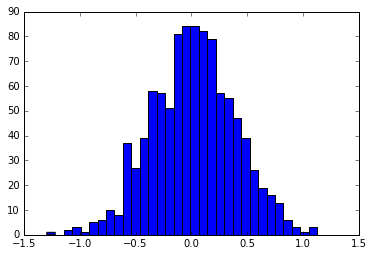

In [273]:
tau = 0.3
beta = 0.9
sample = numpy.random.normal(scale=beta*tau, size=2000)
pair_sums = numpy.array([sum(pair) for pair in zip(sample[:-1:2], sample[1::2])])
plt.hist(pair_sums, bins=32);
(len(pair_sums[(pair_sums > tau)])/float(len(pair_sums)))

In [274]:
beta*tau

0.27

In [140]:
#r1 = results.merge(w[['TeamID', 'Team', 'Rank']], left_on='WTeamID', right_on='TeamID', how='left')
#r1 = r1.rename(index=str, columns={"Team": "WTeamName", "Rank": "WRank"}).drop('TeamID', axis=1)
#r1 = r1.merge(w[['TeamID', 'Team', 'Rank']], left_on='LTeamID', right_on='TeamID', how='left')
#r1 = r1.rename(index=str, columns={"Team": "LTeamName", "Rank": "LRank"}).drop('TeamID', axis=1)
#r1['WRank_diff_LRank'] = r1['WRank'] - r1['LRank']

r1[['WTeamName', 'WRank', 'LTeamName', 'LRank', 'WRank_diff_LRank']][20:24]

,WTeamName,WRank,LTeamName,LRank,WRank_diff_LRank
20,West Virginia,0.214910,Murray St,1.194312,-0.979402
21,Florida,0.374808,UCLA,0.738080,-0.363272
22,Arkansas,0.414969,Butler,0.460196,-0.045227
23,Virginia Tech,0.511047,Alabama,0.753496,-0.242449


In [375]:
rounds_output_file = 'rounds_win_pct.csv'
with open(rounds_output_file, 'w') as output_file:
    print '|'.join(['Scenario', 'Round', 'Team', 'Win_Pct'])
    for scn, winners in all_winners.iteritems():
        for rnd in [1, 2, 3, 4, 5, 6]:
            z = float(len(winners[rnd]))
            for team, ws in sorted(Counter(reduce(lambda x, y: x + y, winners[rnd])).iteritems()):
                print '|'.join(map(str, [scn, rnd, team, ws/z]))
                print >> output_file, '|'.join(map(str, [scn, rnd, team, ws/z]))

Scenario|Round|Team|Win_Pct
data/brackets/bracket_a01_b001_s10_pen|1|Alabama|0.01
data/brackets/bracket_a01_b001_s10_pen|1|Arizona|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Arkansas|0.64
data/brackets/bracket_a01_b001_s10_pen|1|Auburn|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Butler|0.36
data/brackets/bracket_a01_b001_s10_pen|1|Cincinnati|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Clemson|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Creighton|0.63
data/brackets/bracket_a01_b001_s10_pen|1|Duke|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Florida|0.99
data/brackets/bracket_a01_b001_s10_pen|1|Florida St|0.63
data/brackets/bracket_a01_b001_s10_pen|1|Gonzaga|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Houston|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Kansas|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Kansas St|0.37
data/brackets/bracket_a01_b001_s10_pen|1|Kentucky|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Miami FL|1.0
data/brackets/bracket_a01_b001_s10_pen|1|Michigan|1.0
dat

In [113]:
streak[(streak['Season'] == 2018) & (streak['TeamName'].str.contains('Cin'))]

,Season,StreakLen,TeamID,TeamName,streak
2838,2018,2,1153,Cincinnati,1.000
5977,2018,3,1153,Cincinnati,1.000
9116,2018,4,1153,Cincinnati,1.000
12255,2018,6,1153,Cincinnati,1.000
15394,2018,8,1153,Cincinnati,0.875
18533,2018,10,1153,Cincinnati,0.800


In [76]:
for brk in stats:
    scn_res = pandas.DataFrame(stats[brk]['slot_results'])
    scn_res_gb = scn_res.groupby('slot').max().reset_index()
    print brk, scn_res_gb[scn_res_gb['slot'] == 4].values

data/brackets/bracket_a01_b005_s06_pen [[4 0.36 'Virginia']]
data/brackets/bracket_a02_b005_s06 [[4 0.84 'Villanova']]
data/brackets/bracket_a00_b005_sNA [[4 0.31 'Virginia']]
data/brackets/bracket_a01_b000_s10 [[4 1.0 'Villanova']]
data/brackets/bracket_a00_b001_sNA [[4 0.56 'Virginia']]
data/brackets/bracket_a02_b005_s10_pen [[4 0.39 'Virginia']]
data/brackets/bracket_a01_b005_s10_pen [[4 0.32 'Virginia']]
data/brackets/bracket_pp [[4 1.0 'Virginia']]
data/brackets/bracket_a02_b000_s10 [[4 1.0 'Villanova']]
data/brackets/bracket_a01_b001_s06 [[4 0.86 'Villanova']]
data/brackets/bracket_a01_b000_s06 [[4 1.0 'Villanova']]
data/brackets/bracket_a02_b005_s10 [[4 0.25 'Virginia']]
data/brackets/bracket_a01_b005_s06 [[4 0.44 'Virginia']]
data/brackets/bracket_a01_b005_s10 [[4 0.42 'Virginia']]
data/brackets/bracket_a02_b001_s10 [[4 0.72 'Villanova']]
data/brackets/bracket_a01_b001_s10 [[4 0.86 'Villanova']]
data/brackets/bracket_a02_b005_s06_pen [[4 0.73 'Villanova']]
data/brackets/bracket

In [37]:
flat = list()
for ctr, item in enumerate(Counter(final_teams).most_common()):
    copies = [reduce(lambda x, y: x + y, item[0]) for i in range(item[1])]
    flat.extend(copies)
    
    if ctr < 3:
        print item[1], item[0]
        

11 (('Cincinnati', 'North Carolina'), ('Villanova', 'Kansas'), ('Villanova', 'Cincinnati'))
7 (('Cincinnati', 'North Carolina'), ('Villanova', 'Duke'), ('Cincinnati', 'Villanova'))
6 (('Cincinnati', 'North Carolina'), ('Villanova', 'Duke'), ('Villanova', 'Cincinnati'))


In [48]:
t1, t2, t3, t4, t5, t6 = zip(*flat)

for k, t in enumerate(zip(*flat)):
    z = len(t)
    for ctr, item in enumerate(Counter(t).most_common()):
        if k in [0, 2, 4]:
            print '{} {} {}'.format(k, item[0], item[1]/float(z))
    print

0 Cincinnati 0.65
0 Virginia 0.31
0 North Carolina 0.04


2 Villanova 0.55
2 Kansas 0.21
2 Duke 0.11
2 Purdue 0.07
2 Michigan St 0.06


4 Cincinnati 0.34
4 Villanova 0.32
4 Virginia 0.16
4 Kansas 0.09
4 Duke 0.04
4 Purdue 0.03
4 Michigan St 0.02




In [9]:
seeds.merge(w, on='TeamID').sort_values('Rank')[:8]

,Season,Seed,TeamID,Team,norm_rank,streak,Rank
17,2018,X01,1438,Virginia,0.000000,0.0,0.070806
52,2018,Z02,1181,Duke,0.029640,0.7,0.074945
33,2018,Y01,1437,Villanova,0.000000,0.8,0.075523
51,2018,Z01,1242,Kansas,0.015842,0.8,0.084168
18,2018,X02,1153,Cincinnati,0.005110,0.8,0.089418
53,2018,Z03,1277,Michigan St,0.011243,0.9,0.100562
1,2018,W02,1314,North Carolina,0.038838,0.7,0.115752
34,2018,Y02,1345,Purdue,0.043437,0.6,0.125969


In [10]:
rounds[5][['WTeamName', 'LTeamName']]

,WTeamName,LTeamName
0,Virginia,North Carolina
1,Duke,Villanova


In [11]:
rounds[6][['WTeamName', 'LTeamName']]

,WTeamName,LTeamName
0,Virginia,Duke
